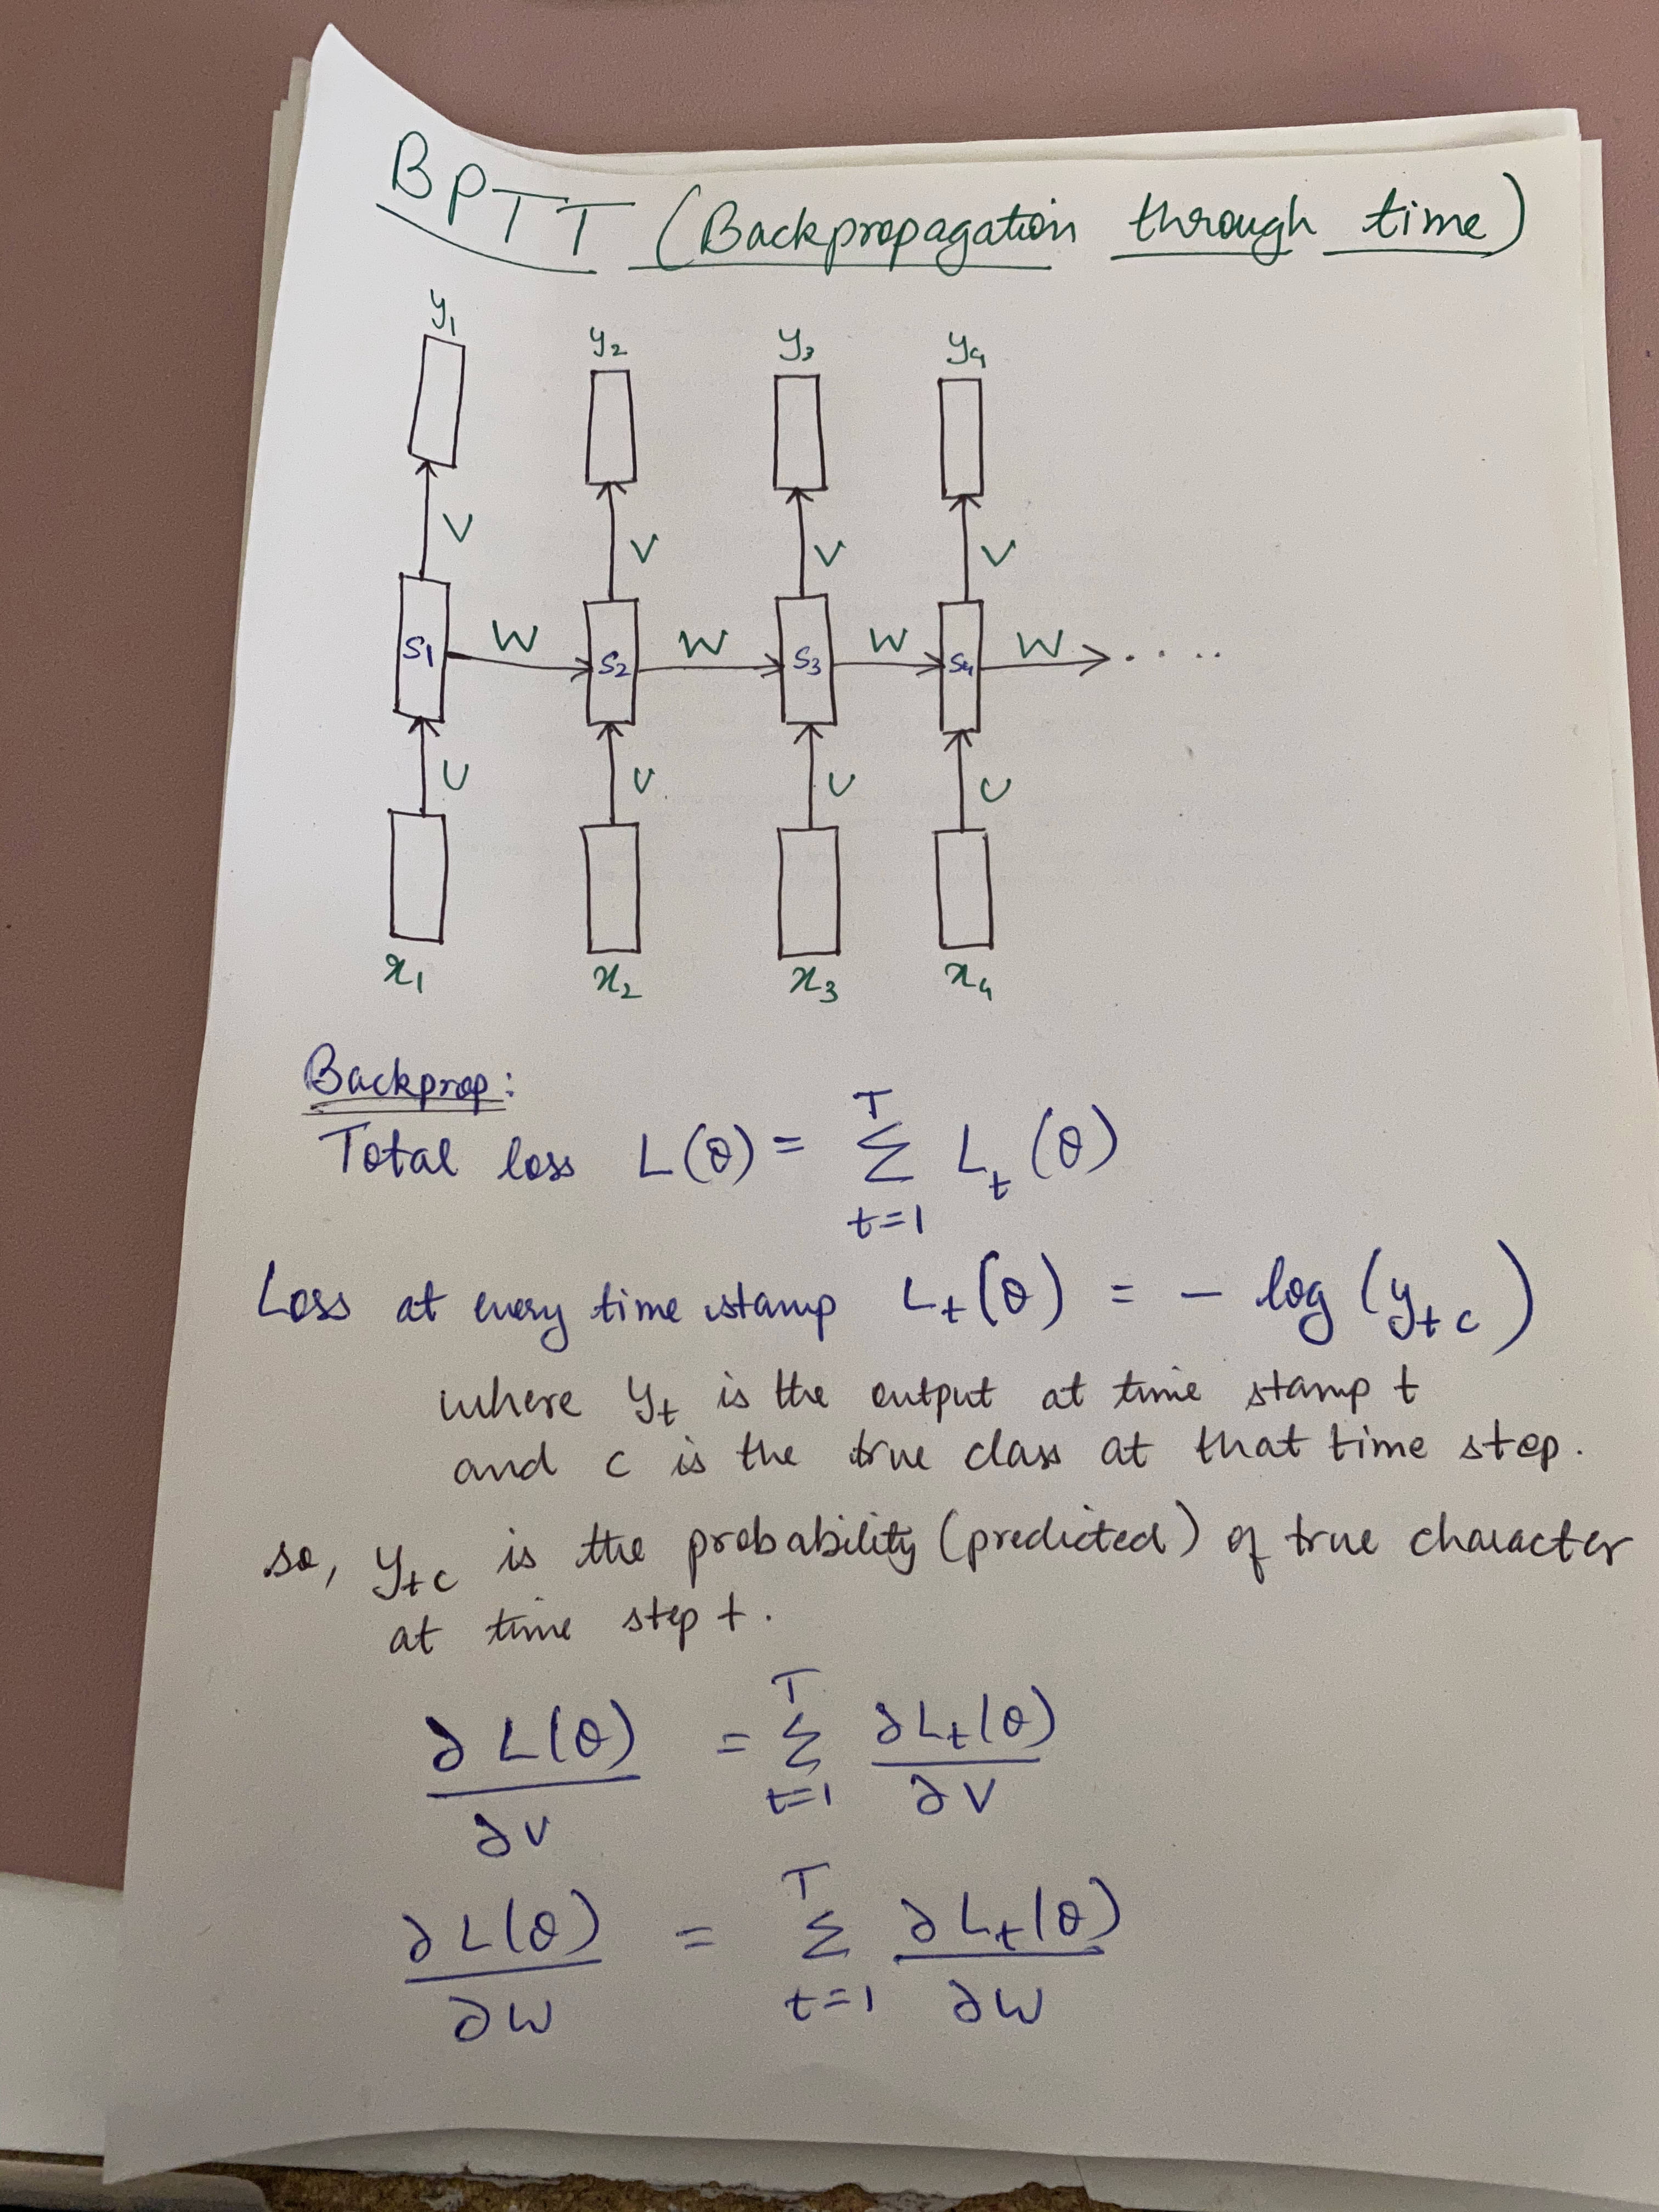

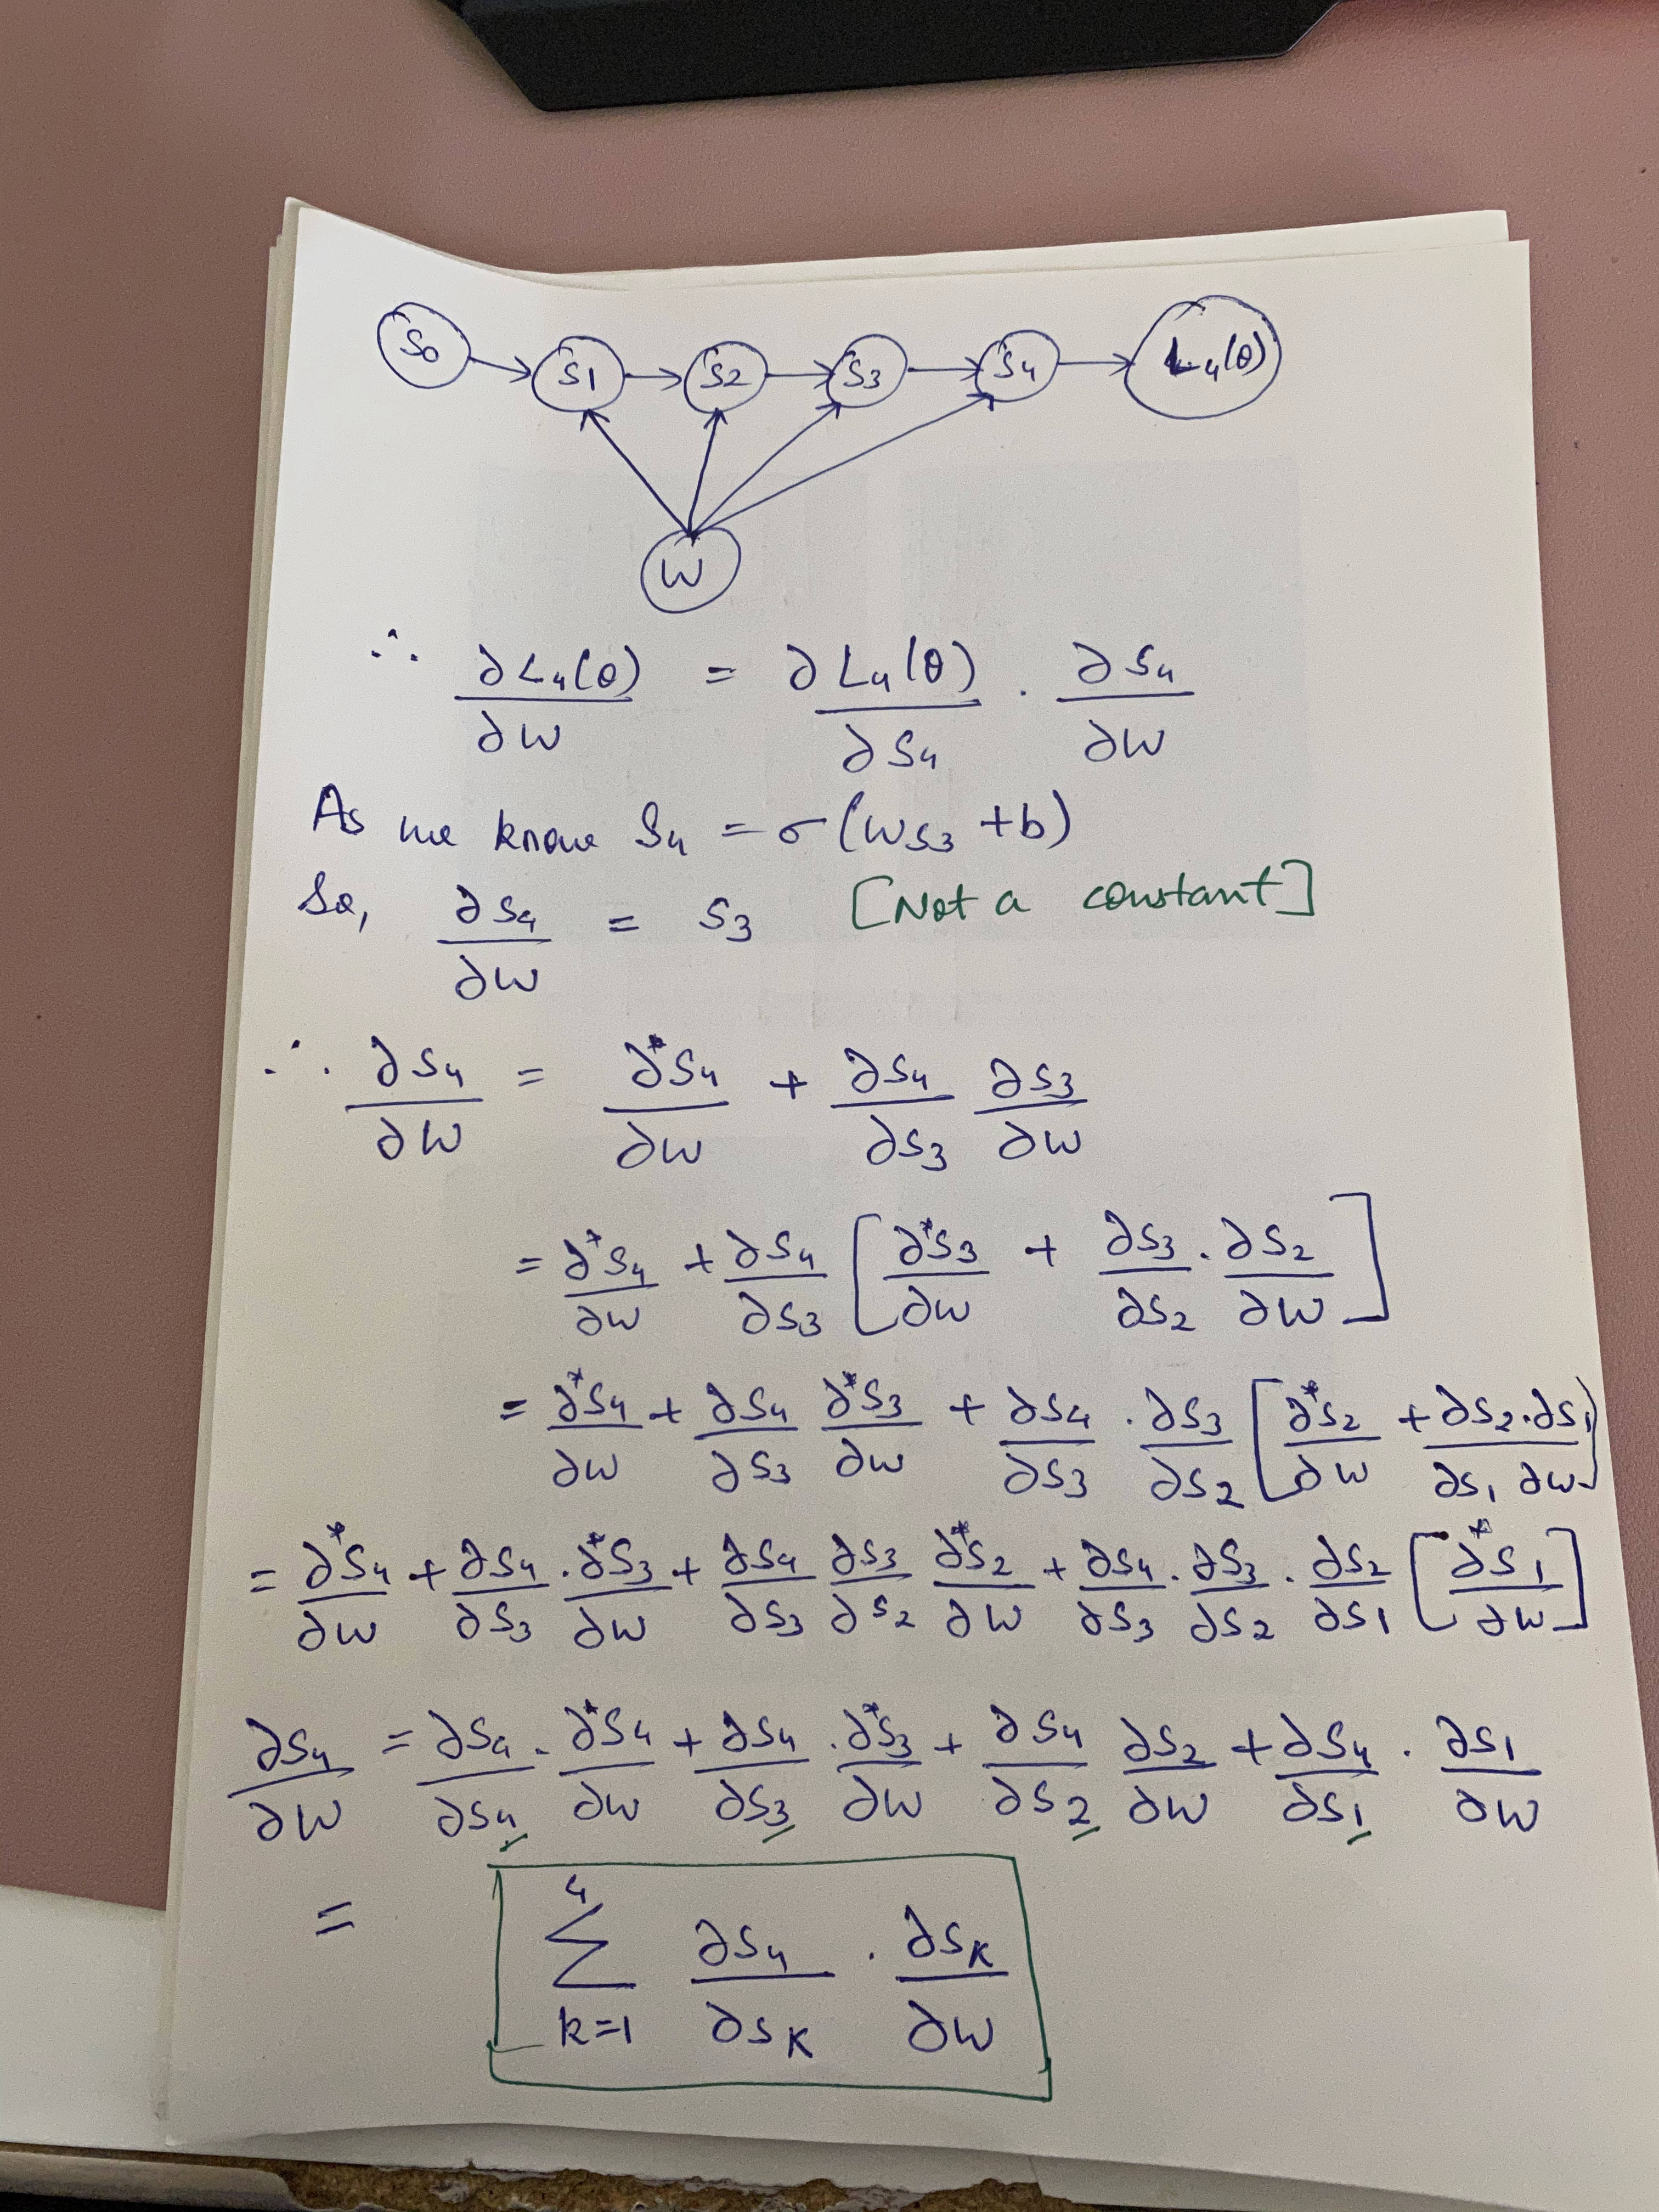

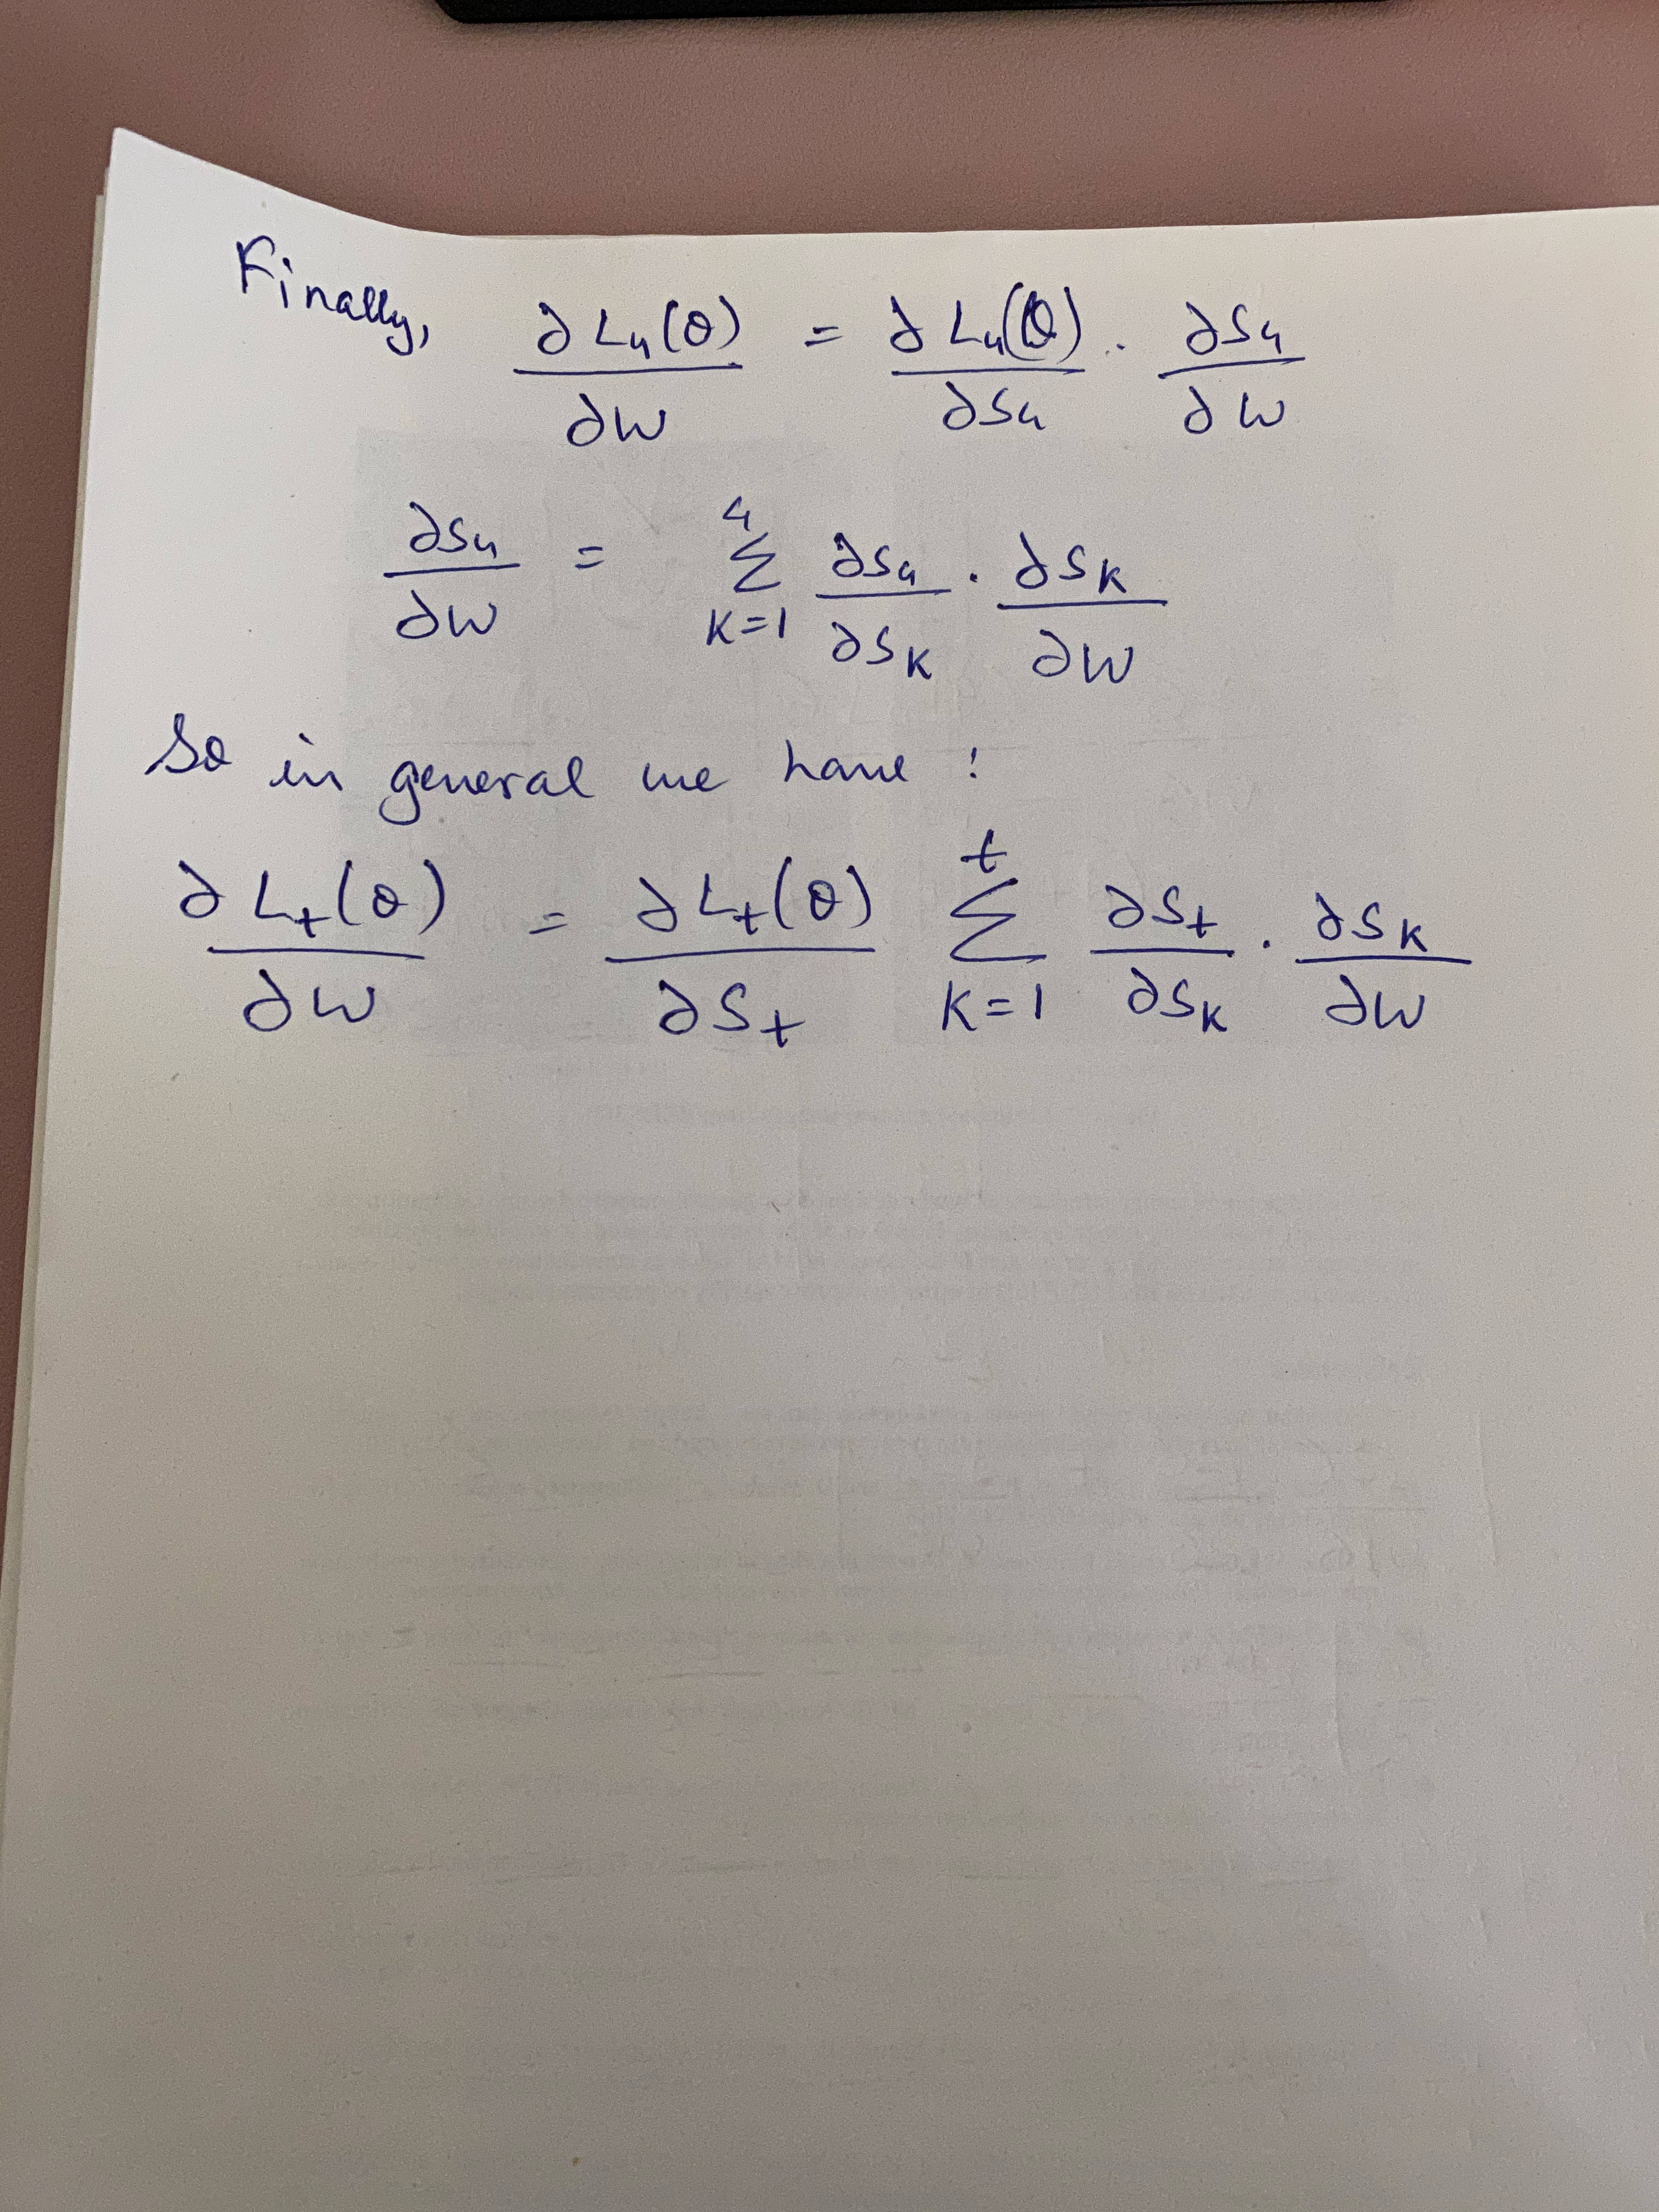

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

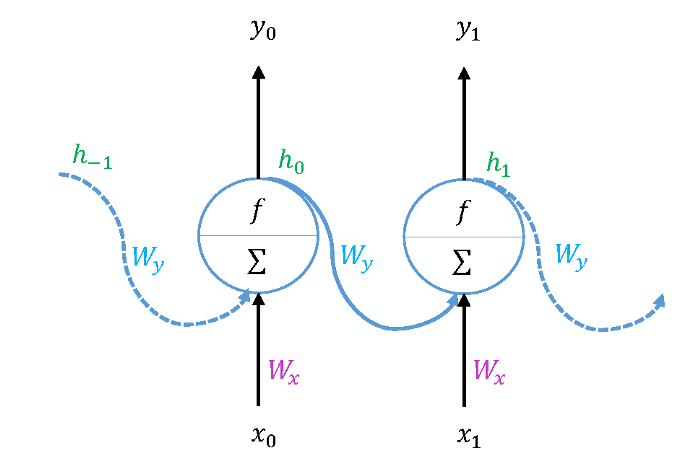

In [3]:
class RNN(nn.Module):
    def __init__(self,n_inputs, n_neurons):
        super(RNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1
        
        self.b = torch.zeros(1, n_neurons) # 1 X 4
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1
        
        return self.Y0, self.Y1

In [4]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0], 
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0], 
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = RNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)
print(Y0_val)
print(Y1_val)

tensor([[ 0.4057],
        [-0.9940],
        [-1.0000],
        [-1.0000]])
tensor([[-1.0000],
        [ 0.2545],
        [-1.0000],
        [-0.9982]])


## Stock Price Prediction

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [30]:
train_csv = './data/Stock_data/AMZNtrain.csv'
data = pd.read_csv(train_csv)
data.head()

Date        Open        High         Low       Close   Adj Close  \
0  2014-01-02  398.799988  399.359985  394.019989  397.970001  397.970001   
1  2014-01-03  398.290009  402.709991  396.220001  396.440002  396.440002   
2  2014-01-06  395.850006  397.000000  388.420013  393.630005  393.630005   
3  2014-01-07  395.040009  398.470001  394.290009  398.029999  398.029999   
4  2014-01-08  398.470001  403.000000  396.040009  401.920013  401.920013   

    Volume  
0  2137800  
1  2210200  
2  3170600  
3  1916000  
4  2316500

In [31]:
from sklearn.preprocessing import MinMaxScaler

price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
#print(price['Close'])
#price = scaler.fit_transform(price.values.reshape(-1,1))
#print(price)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
#Splitting the data into train & test
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (990, 19, 1)
y_train.shape =  (990, 1)
x_test.shape =  (248, 19, 1)
y_test.shape =  (248, 1)


In [33]:
#converting input from numpy array into tensors 
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(type(x_train))

<class 'torch.Tensor'>


In [34]:
#Initialising variables
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [35]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        #RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        ##Fully Connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True)
       
        out, h = self.rnn(x, h.detach())
        out = out[ :, -1, :]
        out = self.fc(out) # out is the predicted probability 
        print(h)
        return out

In [36]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
#specifying loss
criterion = torch.nn.MSELoss(reduction='mean')
print(criterion)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

MSELoss()


In [37]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
rnn = []
for t in range(num_epochs):
    y_train_pred = model(x_train.float())
    loss = criterion(y_train_pred.float(), y_train.float())
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

tensor([[[ 0.2372, -0.1928, -0.1179,  ..., -0.1059,  0.5451,  0.0157],
         [ 0.2354, -0.1898, -0.1147,  ..., -0.1093,  0.5432,  0.0190],
         [ 0.2398, -0.1968, -0.1219,  ..., -0.1013,  0.5480,  0.0117],
         ...,
         [ 0.1569,  0.0435,  0.0351,  ..., -0.0944,  0.2767, -0.0170],
         [ 0.1585,  0.0411,  0.0328,  ..., -0.0913,  0.2786, -0.0200],
         [ 0.1563,  0.0441,  0.0361,  ..., -0.0955,  0.2764, -0.0156]],

        [[ 0.3816,  0.1679,  0.1932,  ..., -0.2595,  0.1768,  0.2394],
         [ 0.3827,  0.1670,  0.1943,  ..., -0.2594,  0.1759,  0.2397],
         [ 0.3800,  0.1693,  0.1919,  ..., -0.2594,  0.1779,  0.2396],
         ...,
         [ 0.3870,  0.1796,  0.1643,  ..., -0.2118,  0.1063,  0.2155],
         [ 0.3859,  0.1809,  0.1632,  ..., -0.2114,  0.1066,  0.2157],
         [ 0.3875,  0.1798,  0.1648,  ..., -0.2112,  0.1054,  0.2161]]],
       grad_fn=<StackBackward>)
Epoch  0 MSE:  0.42271316051483154
tensor([[[ 0.2104, -0.2578, -0.2789,  ...,  0.096

tensor([[[ 0.0505,  0.0404,  0.0023,  ...,  0.2283,  0.3738, -0.3066],
         [ 0.0483,  0.0432,  0.0053,  ...,  0.2245,  0.3713, -0.3033],
         [ 0.0540,  0.0367, -0.0023,  ...,  0.2330,  0.3778, -0.3100],
         ...,
         [ 0.1002,  0.2789,  0.3085,  ..., -0.0360, -0.0740, -0.2737],
         [ 0.1037,  0.2768,  0.3063,  ..., -0.0332, -0.0715, -0.2764],
         [ 0.1023,  0.2789,  0.3090,  ..., -0.0365, -0.0729, -0.2731]],

        [[ 0.6820,  0.4845, -0.2085,  ...,  0.0917,  0.2800, -0.0512],
         [ 0.6820,  0.4824, -0.2063,  ...,  0.0903,  0.2777, -0.0496],
         [ 0.6819,  0.4874, -0.2127,  ...,  0.0943,  0.2841, -0.0536],
         ...,
         [ 0.2853,  0.2076, -0.0141,  ..., -0.0334, -0.0572,  0.0670],
         [ 0.2841,  0.2100, -0.0170,  ..., -0.0314, -0.0548,  0.0655],
         [ 0.2864,  0.2085, -0.0144,  ..., -0.0326, -0.0566,  0.0667]]],
       grad_fn=<StackBackward>)
Epoch  8 MSE:  0.018019763752818108
tensor([[[ 0.0234,  0.0241, -0.0191,  ...,  0.25

tensor([[[-0.0400,  0.0103, -0.0237,  ...,  0.2893,  0.3936, -0.2512],
         [-0.0416,  0.0134, -0.0207,  ...,  0.2849,  0.3912, -0.2478],
         [-0.0345,  0.0060, -0.0290,  ...,  0.2939,  0.3980, -0.2543],
         ...,
         [ 0.0447,  0.2315,  0.2707,  ..., -0.0139, -0.0854, -0.2204],
         [ 0.0496,  0.2287,  0.2680,  ..., -0.0106, -0.0824, -0.2231],
         [ 0.0483,  0.2309,  0.2709,  ..., -0.0136, -0.0829, -0.2205]],

        [[ 0.6810,  0.3986, -0.2487,  ...,  0.0748,  0.3959, -0.1429],
         [ 0.6804,  0.3955, -0.2464,  ...,  0.0735,  0.3933, -0.1411],
         [ 0.6818,  0.4038, -0.2552,  ...,  0.0794,  0.4016, -0.1473],
         ...,
         [ 0.1562,  0.1006,  0.0242,  ..., -0.0918, -0.0596,  0.0475],
         [ 0.1565,  0.1053,  0.0193,  ..., -0.0883, -0.0557,  0.0449],
         [ 0.1606,  0.1032,  0.0228,  ..., -0.0896, -0.0583,  0.0464]]],
       grad_fn=<StackBackward>)
Epoch  20 MSE:  0.0012699323706328869
tensor([[[-0.0357, -0.0044, -0.0424,  ...,  0.

tensor([[[-0.0206,  0.0025, -0.0208,  ...,  0.2875,  0.3869, -0.2378],
         [-0.0218,  0.0057, -0.0177,  ...,  0.2827,  0.3846, -0.2346],
         [-0.0140, -0.0021, -0.0263,  ...,  0.2924,  0.3916, -0.2411],
         ...,
         [ 0.0261,  0.2029,  0.2338,  ...,  0.0043, -0.0670, -0.1922],
         [ 0.0314,  0.1997,  0.2307,  ...,  0.0079, -0.0637, -0.1950],
         [ 0.0298,  0.2020,  0.2339,  ...,  0.0049, -0.0640, -0.1926]],

        [[ 0.6730,  0.3592, -0.2523,  ...,  0.0934,  0.3758, -0.1644],
         [ 0.6724,  0.3559, -0.2501,  ...,  0.0925,  0.3731, -0.1627],
         [ 0.6743,  0.3658, -0.2598,  ...,  0.0989,  0.3824, -0.1698],
         ...,
         [ 0.1801,  0.0955,  0.0206,  ..., -0.0864, -0.0350,  0.0488],
         [ 0.1810,  0.1011,  0.0150,  ..., -0.0824, -0.0301,  0.0456],
         [ 0.1857,  0.0985,  0.0189,  ..., -0.0839, -0.0330,  0.0472]]],
       grad_fn=<StackBackward>)
Epoch  32 MSE:  0.0012747577857226133
tensor([[[-1.7271e-02, -3.2264e-03, -2.7746e-0

tensor([[[-7.2737e-03, -8.6743e-03, -3.0324e-02,  ...,  2.9601e-01,
           3.9882e-01, -2.3266e-01],
         [-8.5306e-03, -5.4904e-03, -2.7102e-02,  ...,  2.9122e-01,
           3.9662e-01, -2.2952e-01],
         [-6.6094e-04, -1.3413e-02, -3.5841e-02,  ...,  3.0096e-01,
           4.0362e-01, -2.3595e-01],
         ...,
         [ 2.1382e-02,  1.9816e-01,  2.2725e-01,  ...,  5.3205e-03,
          -6.8318e-02, -1.8594e-01],
         [ 2.6766e-02,  1.9494e-01,  2.2413e-01,  ...,  8.9518e-03,
          -6.5084e-02, -1.8866e-01],
         [ 2.5101e-02,  1.9728e-01,  2.2735e-01,  ...,  5.9436e-03,
          -6.5379e-02, -1.8631e-01]],

        [[ 6.8916e-01,  3.6071e-01, -2.6613e-01,  ...,  1.0950e-01,
           3.9186e-01, -1.8868e-01],
         [ 6.8857e-01,  3.5745e-01, -2.6397e-01,  ...,  1.0858e-01,
           3.8902e-01, -1.8689e-01],
         [ 6.9051e-01,  3.6757e-01, -2.7385e-01,  ...,  1.1515e-01,
           3.9840e-01, -1.9405e-01],
         ...,
         [ 1.7503e-01,  8

tensor([[[-0.0013, -0.0096, -0.0271,  ...,  0.2933,  0.3927, -0.2312],
         [-0.0026, -0.0064, -0.0238,  ...,  0.2885,  0.3905, -0.2281],
         [ 0.0053, -0.0143, -0.0327,  ...,  0.2984,  0.3975, -0.2345],
         ...,
         [ 0.0198,  0.1972,  0.2251,  ...,  0.0033, -0.0719, -0.1836],
         [ 0.0252,  0.1940,  0.2220,  ...,  0.0069, -0.0687, -0.1863],
         [ 0.0235,  0.1963,  0.2252,  ...,  0.0039, -0.0689, -0.1840]],

        [[ 0.6722,  0.3505, -0.2643,  ...,  0.1110,  0.3797, -0.1960],
         [ 0.6716,  0.3472, -0.2621,  ...,  0.1101,  0.3768, -0.1942],
         [ 0.6736,  0.3576, -0.2721,  ...,  0.1167,  0.3865, -0.2015],
         ...,
         [ 0.1734,  0.0863,  0.0300,  ..., -0.0842, -0.0497,  0.0636],
         [ 0.1744,  0.0923,  0.0240,  ..., -0.0800, -0.0445,  0.0604],
         [ 0.1793,  0.0895,  0.0279,  ..., -0.0815, -0.0473,  0.0619]]],
       grad_fn=<StackBackward>)
Epoch  48 MSE:  0.0003642674710135907
tensor([[[-0.0013, -0.0080, -0.0244,  ...,  0.

tensor([[[ 1.7496e-03, -7.8403e-03, -2.1776e-02,  ...,  2.8874e-01,
           3.8407e-01, -2.3120e-01],
         [ 4.4143e-04, -4.6567e-03, -1.8456e-02,  ...,  2.8394e-01,
           3.8182e-01, -2.2813e-01],
         [ 8.5263e-03, -1.2677e-02, -2.7324e-02,  ...,  2.9381e-01,
           3.8887e-01, -2.3452e-01],
         ...,
         [ 2.1550e-02,  1.9252e-01,  2.1851e-01,  ...,  5.8576e-03,
          -6.3934e-02, -1.8285e-01],
         [ 2.7053e-02,  1.8919e-01,  2.1526e-01,  ...,  9.5865e-03,
          -6.0635e-02, -1.8556e-01],
         [ 2.5330e-02,  1.9154e-01,  2.1851e-01,  ...,  6.5748e-03,
          -6.0829e-02, -1.8322e-01]],

        [[ 6.5013e-01,  3.4029e-01, -2.5966e-01,  ...,  1.0846e-01,
           3.6351e-01, -1.9823e-01],
         [ 6.4942e-01,  3.3700e-01, -2.5744e-01,  ...,  1.0758e-01,
           3.6061e-01, -1.9633e-01],
         [ 6.5163e-01,  3.4761e-01, -2.6760e-01,  ...,  1.1428e-01,
           3.7057e-01, -2.0376e-01],
         ...,
         [ 2.0733e-01,  9

tensor([[[ 0.0063, -0.0102, -0.0204,  ...,  0.2885,  0.3823, -0.2313],
         [ 0.0049, -0.0070, -0.0170,  ...,  0.2837,  0.3800, -0.2283],
         [ 0.0130, -0.0151, -0.0259,  ...,  0.2936,  0.3870, -0.2346],
         ...,
         [ 0.0238,  0.1922,  0.2177,  ...,  0.0026, -0.0638, -0.1845],
         [ 0.0293,  0.1889,  0.2144,  ...,  0.0064, -0.0605, -0.1872],
         [ 0.0276,  0.1912,  0.2176,  ...,  0.0034, -0.0607, -0.1849]],

        [[ 0.6362,  0.3388, -0.2630,  ...,  0.1088,  0.3587, -0.2123],
         [ 0.6354,  0.3355, -0.2607,  ...,  0.1079,  0.3557, -0.2103],
         [ 0.6377,  0.3462, -0.2709,  ...,  0.1146,  0.3658, -0.2177],
         ...,
         [ 0.2238,  0.0971,  0.0241,  ..., -0.0696, -0.0458,  0.0677],
         [ 0.2254,  0.1033,  0.0180,  ..., -0.0652, -0.0403,  0.0644],
         [ 0.2304,  0.1005,  0.0219,  ..., -0.0666, -0.0431,  0.0658]]],
       grad_fn=<StackBackward>)
Epoch  68 MSE:  0.0002789036079775542
tensor([[[ 0.0069, -0.0110, -0.0211,  ...,  0.

tensor([[[ 8.6043e-03, -1.1609e-02, -1.9506e-02,  ...,  2.8838e-01,
           3.8154e-01, -2.3180e-01],
         [ 7.0994e-03, -8.3905e-03, -1.6109e-02,  ...,  2.8365e-01,
           3.7926e-01, -2.2876e-01],
         [ 1.5285e-02, -1.6435e-02, -2.5061e-02,  ...,  2.9349e-01,
           3.8624e-01, -2.3509e-01],
         ...,
         [ 2.5194e-02,  1.9335e-01,  2.1914e-01,  ..., -9.3156e-04,
          -6.5963e-02, -1.8638e-01],
         [ 3.0707e-02,  1.9002e-01,  2.1584e-01,  ...,  2.7914e-03,
          -6.2671e-02, -1.8906e-01],
         [ 2.8966e-02,  1.9235e-01,  2.1907e-01,  ..., -2.2636e-04,
          -6.2860e-02, -1.8671e-01]],

        [[ 6.2847e-01,  3.3937e-01, -2.6545e-01,  ...,  1.0858e-01,
           3.5589e-01, -2.2108e-01],
         [ 6.2770e-01,  3.3601e-01, -2.6308e-01,  ...,  1.0754e-01,
           3.5289e-01, -2.1900e-01],
         [ 6.2999e-01,  3.4674e-01, -2.7337e-01,  ...,  1.1438e-01,
           3.6303e-01, -2.2645e-01],
         ...,
         [ 2.2856e-01,  9

tensor([[[ 0.0100, -0.0113, -0.0168,  ...,  0.2864,  0.3782, -0.2328],
         [ 0.0084, -0.0080, -0.0134,  ...,  0.2817,  0.3759, -0.2297],
         [ 0.0167, -0.0161, -0.0224,  ...,  0.2915,  0.3829, -0.2361],
         ...,
         [ 0.0275,  0.1923,  0.2180,  ..., -0.0019, -0.0633, -0.1881],
         [ 0.0331,  0.1890,  0.2147,  ...,  0.0018, -0.0599, -0.1908],
         [ 0.0313,  0.1913,  0.2179,  ..., -0.0012, -0.0601, -0.1884]],

        [[ 0.6170,  0.3375, -0.2650,  ...,  0.1067,  0.3482, -0.2253],
         [ 0.6162,  0.3342, -0.2626,  ...,  0.1056,  0.3452, -0.2231],
         [ 0.6186,  0.3449, -0.2729,  ...,  0.1125,  0.3554, -0.2306],
         ...,
         [ 0.2456,  0.1010,  0.0246,  ..., -0.0625, -0.0508,  0.0718],
         [ 0.2474,  0.1073,  0.0184,  ..., -0.0580, -0.0452,  0.0686],
         [ 0.2525,  0.1045,  0.0222,  ..., -0.0594, -0.0481,  0.0700]]],
       grad_fn=<StackBackward>)
Epoch  84 MSE:  0.00024128063523676246
tensor([[[ 0.0103, -0.0117, -0.0171,  ...,  0

tensor([[[ 1.1399e-02, -1.1421e-02, -1.5001e-02,  ...,  2.8506e-01,
           3.7623e-01, -2.3373e-01],
         [ 9.8135e-03, -8.1931e-03, -1.1569e-02,  ...,  2.8037e-01,
           3.7392e-01, -2.3071e-01],
         [ 1.8092e-02, -1.6247e-02, -2.0559e-02,  ...,  2.9019e-01,
           3.8090e-01, -2.3701e-01],
         ...,
         [ 2.9644e-02,  1.9200e-01,  2.1792e-01,  ..., -3.6282e-03,
          -6.2017e-02, -1.8997e-01],
         [ 3.5196e-02,  1.8866e-01,  2.1458e-01,  ...,  1.0855e-04,
          -5.8677e-02, -1.9264e-01],
         [ 3.3412e-02,  1.9098e-01,  2.1780e-01,  ..., -2.8962e-03,
          -5.8860e-02, -1.9029e-01]],

        [[ 6.0875e-01,  3.3723e-01, -2.6560e-01,  ...,  1.0550e-01,
           3.4265e-01, -2.2999e-01],
         [ 6.0793e-01,  3.3384e-01, -2.6315e-01,  ...,  1.0437e-01,
           3.3962e-01, -2.2782e-01],
         [ 6.1034e-01,  3.4467e-01, -2.7353e-01,  ...,  1.1131e-01,
           3.4993e-01, -2.3531e-01],
         ...,
         [ 2.5786e-01,  1

Training time: 6.052474021911621


In [40]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))
print(predict)

               0
0     390.928680
1     394.856628
2     377.605621
3     351.774353
4     346.888733
5     353.392365
6     358.497986
7     360.778351
8     361.949158
9     362.891632
10    357.252808
11    356.145844
12    360.020172
13    359.378265
14    352.877167
15    350.522461
16    351.572113
17    354.054413
18    358.778961
19    361.978607
20    362.236877
21    362.842712
22    362.978607
23    364.555115
24    370.677948
25    374.494781
26    373.567535
27    371.488770
28    370.553253
29    371.709595
..           ...
960  1143.046753
961  1139.045166
962  1144.008545
963  1161.842041
964  1189.704346
965  1207.802124
966  1206.060547
967  1180.276611
968  1173.497314
969  1179.442261
970  1161.385132
971  1144.365601
972  1153.952515
973  1173.217651
974  1177.458984
975  1175.040527
976  1174.290161
977  1175.015747
978  1181.625366
979  1189.803955
980  1198.406982
981  1199.878174
982  1190.930054
983  1183.183716
984  1180.044434
985  1184.951904
986  1192.7730

In [39]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

ModuleNotFoundError: No module named 'seaborn'